In [4]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras import Model
from model_files import config
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

seed = 42

In [5]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []

    # loop over the image paths
    for imagePath in imagePaths:

        # load the image and resize it to be a fixed 128x128 pixels
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))

        # add the image to the data lists
        data.append(image)

    # return the data list as a NumPy array
    return np.array(data, dtype= "float32")

In [6]:
print("[INFO] loading data...")
fireData = load_dataset(config.FIRE_PATH)
nonFireData = load_dataset(config.NON_FIRE_PATH)

[INFO] loading data...


In [7]:
# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))

In [8]:
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])

data /= 255

In [9]:
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [10]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=config.TEST_SPLIT, random_state=seed)


In [11]:

# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Pre-trained model with image augmentation: 
#### Using a pre-trained model as a feature extractor

In [14]:
from keras.applications import vgg16
from keras.models import Model
import keras

pre_trained_model = vgg16.VGG16(input_shape = (128,128,3),
                                include_top = False,
                                weights = 'imagenet'
                                )
output = pre_trained_model.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(pre_trained_model.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x1a3304aa90>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x107d5f668>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x1a390a7e80>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x1a3a8d6d68>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x1a3a8c6278>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x1a36ae7748>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x1a33124400>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x1a3310bb38>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x1a331672e8>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x1a33180780>,block3_conv3,False


(1, 4, 4, 512)


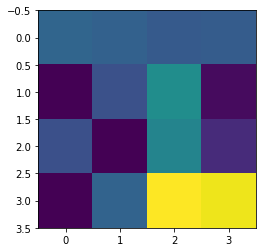

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
bottleneck_feature_example = pre_trained_model.predict(trainX[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [13]:
from tensorflow.keras.applications import vgg16
#from keras.models import Model
from tensorflow.keras.models import Model
import keras

epoch = 70
drop = 0.2
l_rate = 0.001

pre_trained_model = vgg16.VGG16(input_shape = (128,128,3),
                                include_top = False,
                                weights = 'imagenet'
                                )

for layer in pre_trained_model.layers:
  layer.trainable = False


opt = SGD(lr = l_rate, 
                momentum=0.9,
                decay= l_rate / epoch)
      
      # Flatten the output layer to 1 Dimension
x = layers.Flatten()(pre_trained_model.output)
      # Add a Fully Connected Layer with 1024 hidden units/neurons and ReLU activation function
x = layers.Dense(1024, activation = 'relu')(x)
      # Add a Dropout layer with rate of 0.2 
x = layers.Dropout(drop)(x)
      # Add a final Dense Layer with sigmoid activation function for classification
x = layers.Dense(2, activation = 'sigmoid')(x)


model = Model(pre_trained_model.input, x)
model.compile(optimizer= opt,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])


      # train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
                              validation_data= (testX, testY),
                              steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
                              epochs= epoch,
                              verbose=1)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/70
47/47 [==============================] - 367s 8s/step - loss: 0.5589 - acc: 0.7059 - val_loss: 0.4311 - val_acc: 0.7937
Epoch 2/70
47/47 [==============================] - 389s 8s/step - loss: 0.4233 - acc: 0.8041 - val_loss: 0.3606 - val_acc: 0.8546
Epoch 3/70
47/47 [==============================] - 396s 8s/step - loss: 0.3771 - acc: 0.8319 - val_loss: 0.3206 - val_acc: 0.8631
Epoch 4/70
47/47 [==============================] - 400s 9s/step - loss: 0.3521 - acc: 0.8456 - val_loss: 0.3100 - val_acc: 0.8666
Epoch 5/70
47/47 [==============================] - 409s 9s/step - loss: 0.3265 - acc: 0.8544 - val_loss: 0.3100 - val_acc: 0.8596
Epoch 6/70
47/47 [==============================] - 396s 8s/step - loss: 0.3270 - acc: 0.8559 - val_loss: 0.2765 - val_acc: 0.8906
Epoch 7/70
47/47 [======

Epoch 35/70
47/47 [==============================] - 364s 8s/step - loss: 0.2064 - acc: 0.9159 - val_loss: 0.1997 - val_acc: 0.9086
Epoch 36/70
47/47 [==============================] - 361s 8s/step - loss: 0.1943 - acc: 0.9209 - val_loss: 0.1780 - val_acc: 0.9256
Epoch 37/70
47/47 [==============================] - 363s 8s/step - loss: 0.1917 - acc: 0.9247 - val_loss: 0.1717 - val_acc: 0.9261
Epoch 38/70
47/47 [==============================] - 364s 8s/step - loss: 0.1965 - acc: 0.9249 - val_loss: 0.1791 - val_acc: 0.9246
Epoch 39/70
47/47 [==============================] - 367s 8s/step - loss: 0.1798 - acc: 0.9319 - val_loss: 0.1777 - val_acc: 0.9316
Epoch 40/70
47/47 [==============================] - 375s 8s/step - loss: 0.1936 - acc: 0.9237 - val_loss: 0.2048 - val_acc: 0.9091
Epoch 41/70
47/47 [==============================] - 366s 8s/step - loss: 0.1960 - acc: 0.9216 - val_loss: 0.1762 - val_acc: 0.9276
Epoch 42/70
47/47 [==============================] - 419s 9s/step - loss: 0.

In [16]:
## evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=config.BATCH_SIZE)

print(classification_report(testY.argmax(axis=1),
      predictions.argmax(axis=1), target_names=config.CLASSES))

[INFO] evaluating network...
              precision    recall  f1-score   support

    Non-Fire       0.94      0.96      0.95       647
        Fire       0.93      0.89      0.91       354

   micro avg       0.94      0.94      0.94      1001
   macro avg       0.93      0.93      0.93      1001
weighted avg       0.94      0.94      0.94      1001



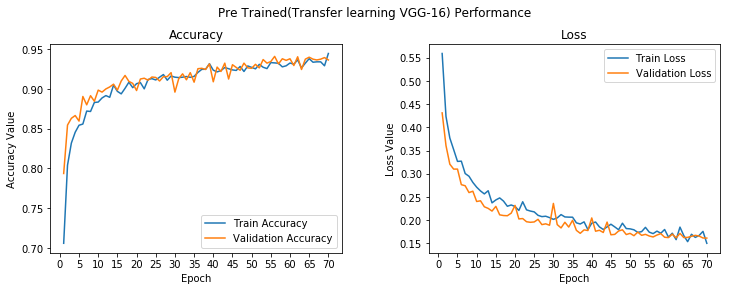

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre Trained(Transfer learning VGG-16) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)


epoch_list = list(range(1,71))
ax1.plot(epoch_list, H.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, H.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, H.history['loss'], label='Train Loss')
ax2.plot(epoch_list, H.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
H.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [28]:
 model.save('fire_nonfire_vgg16_tlearn_cnn.h5')

## Pre-trained CNN model with Fine-tuning and Image Augmentation

In [19]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 4,458,498
Trainable params: 4,458,498
Non-trainable params: 0
_________________________________________________________________


In [20]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x1a3304aa90>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x107d5f668>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x1a390a7e80>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x1a3a8d6d68>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x1a3a8c6278>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x1a36ae7748>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x1a33124400>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x1a3310bb38>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x1a331672e8>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x1a33180780>,block3_conv3,False


In [21]:
epoch = 70
#drop = 0.2
#l_rate = 0.001

vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model_1 = Sequential()
model_1.add(vgg_model)
model_1.add(Dense(512, activation='relu', input_dim=input_shape))
model_1.add(Dropout(0.3))
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(2, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])


      # train the network
print("[INFO] training network...")
H_1 = model_1.fit_generator(aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
                              validation_data= (testX, testY),
                              steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
                              epochs= epoch,
                              verbose=1)

[INFO] training network...
Epoch 1/70
46/46 [==============================] - 672s 15s/step - loss: 0.5268 - accuracy: 0.7245 - val_loss: 0.3059 - val_accuracy: 0.8761
Epoch 2/70
46/46 [==============================] - 698s 15s/step - loss: 0.3182 - accuracy: 0.8552 - val_loss: 0.2094 - val_accuracy: 0.9161
Epoch 3/70
46/46 [==============================] - 708s 15s/step - loss: 0.2436 - accuracy: 0.8953 - val_loss: 0.1714 - val_accuracy: 0.9306
Epoch 4/70
46/46 [==============================] - 651s 14s/step - loss: 0.2131 - accuracy: 0.9118 - val_loss: 0.1919 - val_accuracy: 0.9136
Epoch 5/70
46/46 [==============================] - 550s 12s/step - loss: 0.1741 - accuracy: 0.9311 - val_loss: 0.1194 - val_accuracy: 0.9555
Epoch 6/70
46/46 [==============================] - 566s 12s/step - loss: 0.1527 - accuracy: 0.9406 - val_loss: 0.1147 - val_accuracy: 0.9555
Epoch 7/70
46/46 [==============================] - 603s 13s/step - loss: 0.1393 - accuracy: 0.9452 - val_loss: 0.1134 - 

In [22]:
## evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model_1.predict(testX, batch_size=config.BATCH_SIZE)

print(classification_report(testY.argmax(axis=1),
      predictions.argmax(axis=1), target_names=config.CLASSES))

[INFO] evaluating network...
              precision    recall  f1-score   support

    Non-Fire       0.98      0.98      0.98       647
        Fire       0.97      0.97      0.97       354

   micro avg       0.98      0.98      0.98      1001
   macro avg       0.97      0.97      0.97      1001
weighted avg       0.98      0.98      0.98      1001



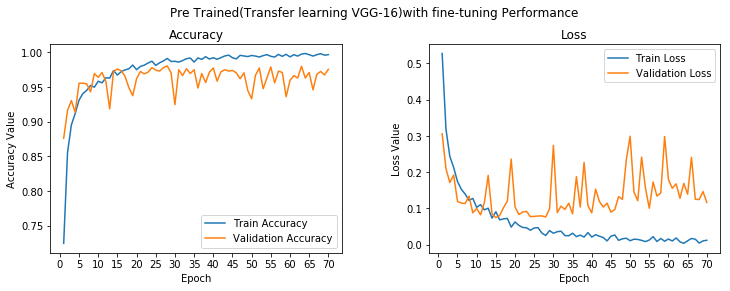

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre Trained(Transfer learning VGG-16)with fine-tuning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)


epoch_list = list(range(1,71))
ax1.plot(epoch_list, H_1.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, H_1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, H_1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, H_1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [27]:
model_1.save('Finetuned_fire_nonfire_vgg16_tlearn_cnn.h5')